## Exploring NEON (National Ecological Observatory Network) AOP (Airborne Operations Platform) and NEON BioRepository Data Together

##### In this project, we will be looking at NEON AOP data for 2016 and 2017 in the GRSM (Great Smokey Mountains) Domain. Between the 2016 and 2017 collection of data, a large fire occurred in the domain leaving a prominent burn scar. We will be using the GEE (Google Earth Engine) API to explore the burn scar using the NBR (Normalize Burn Ratio) to set a threshold to identify burnt areas. We will then us the PyGBIF API (Python Global Biodiversity Information Facility) to pull records from the NEON BioRepository to see if and/or how Carabid beetle traps in the domain were impacted by the fires.

## Part 1: Pulling + Visualizing Imagery and Occurence Records via APIs

#### Step 1: Import and authenticate GEE and geemap with your username and project

In [2]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-krle4401")

#### Step 2: Pull NEON Imagery from GEE

In [3]:
# Define an area of interest, for the imagery, I will simply be using a centroid because I want all
# the imagery from GRSM domain. You can using a bounding box, shapefiles, etc. if you want a more granular
# control of the geographic area
site_center = ee.Geometry.Point([-83.5, 35.7])

# Load Hyperspectral AOP Image Collection
sdr_col = ee.ImageCollection('projects/neon-prod-earthengine/assets/HSI_REFL/001')

# Retrieve all available image IDs to make a list if you want to see everything, but also to cross 
# reference years you may want
image_ids = sdr_col.aggregate_array("system:index").getInfo()
print("Available AOP Image IDs:", image_ids)

# Define a function that allows you to look through multiple years and domains of image collections
def filter_aop_images(years, domains):
    """
    Filters the AOP image collection based on a list of years and domains.
    
    Parameters:
        years (list): List of years (e.g., ["2016", "2017"]).
        domains (list): List of 4-letter site codes (e.g., ["GRSM", "HARV"]).
    
    Returns:
        Dictionary with (year, domain) as key and list of matching image IDs.
    """
    filtered_results = {}

    for year in years:
        for domain in domains:
            matching_ids = [img_id for img_id in image_ids if year in img_id and domain in img_id]
            if matching_ids:
                filtered_results[(year, domain)] = matching_ids

    return filtered_results

# Define years and domains that you want to look at (NOTE: this code can be used from multiple years
# and domains)
years_input = ["2016", "2017"]  # Add multiple years here
domains_input = ["GRSM"]  # Add multiple domains here

# Get image filtered by year and domain
filtered_images = filter_aop_images(years_input, domains_input)

# NEON does not fly every single domain every year so there may be years where imagery is unavailable
# I like to have a conditional statement so I can easily check if there are no images available, but 
# also print a list in case only some years are available
if not filtered_images:
    print(f"No AOP images found for the selected years and domains.")
else:
    print(f"Found AOP images: {filtered_images}")


Available AOP Image IDs: ['2013_CPER_1', '2014_HARV_2', '2014_JERC_1', '2015_MLBS_1', '2015_TALL_1', '2016_CLBJ_1', '2016_GRSM_2', '2016_HARV_3', '2016_JERC_2', '2016_SERC_1', '2016_TALL_2', '2017_CLBJ_2', '2017_CPER_3', '2017_GRSM_3', '2017_HARV_4', '2017_JERC_3', '2017_MLBS_2', '2017_OAES_2', '2017_SERC_3', '2017_SRER_1', '2017_TALL_3', '2018_GUAN_1', '2018_HARV_5', '2018_JERC_4', '2018_MCRA_1', '2018_MLBS_3', '2018_OAES_3', '2018_SRER_2', '2018_TALL_4', '2019_CLBJ_4', '2019_HARV_6', '2019_HEAL_3', '2019_JERC_5', '2019_JORN_3', '2019_NIWO_3', '2019_OAES_4', '2019_SERC_4', '2019_SOAP_4', '2019_SRER_3', '2019_TALL_5', '2020_CPER_5', '2020_CPER_7', '2020_NIWO_4', '2020_RMNP_3', '2020_YELL_3', '2021_ABBY_4', '2021_BONA_4', '2021_CLBJ_5', '2021_CPER_8', '2021_HEAL_4', '2021_JERC_6', '2021_JORN_4', '2021_MCRA_2', '2021_OAES_5', '2021_OSBS_6', '2021_SERC_5', '2021_SJER_5', '2021_SOAP_5', '2021_SRER_4', '2021_TALL_6']
Found AOP images: {('2016', 'GRSM'): ['2016_GRSM_2'], ('2017', 'GRSM'): ['

#### Step 2: Calculate NBR (Normalized Burn Ratio) and visualize for 2016 and 2017 imagery

In [4]:
# NBR Visualization Parameters
nbr_vis_params = {
    'min': -1, 'max': 1,
    'palette': ['white', 'yellow', 'red', 'black']  # typical burn severity color ramp
}

# Function to Compute NBR
def addNBRBands(image):
    nbr = image.normalizedDifference(['B097', 'B220']).rename('NBR')
    return image.addBands(nbr).set({'Sensor': 'AOP'})

# Create a geemap Map instance for NBR visualization
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Loop through filtered images and compute NBR
for (year, domain), image_ids in filtered_images.items():
    for image_id in image_ids:
        # Retrieve the image by its system:index
        aop_image = sdr_col.filter(ee.Filter.eq("system:index", image_id)).first()

        # Compute NBR
        if aop_image:
            aop_nbr = addNBRBands(aop_image).select('NBR')
            print(f"NBR computed for AOP image: {image_id}")

            # Add layer with proper naming
            NBR_Map.addLayer(aop_nbr, nbr_vis_params, f'AOP NBR ({image_id})')

# Save the final interactive HTML map for NBR
html_nbr_filename = f"AOP_NBR_{'_'.join(years_input)}_{'_'.join(domains_input)}.html"
NBR_Map.to_html(filename=html_nbr_filename)

print(f"NBR visualization saved: {html_nbr_filename}")

NBR computed for AOP image: 2016_GRSM_2
NBR computed for AOP image: 2017_GRSM_3
NBR visualization saved: AOP_NBR_2016_2017_GRSM.html


#### Import the Python GBIF API with necessary packages for geometry and data analysis

In [6]:
from pygbif import occurrences as gbif_occ
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd

# GSMNP centroid and bounding box parameters
latitude, longitude = 35.6118, -83.4895
bbox_size_deg = 0.09  # Approx. 10 km (~0.09 degrees)

# Create bounding box polygon
bounding_box_coords = [
    (longitude - bbox_size_deg, latitude - bbox_size_deg),  # Bottom-left
    (longitude + bbox_size_deg, latitude - bbox_size_deg),  # Bottom-right
    (longitude + bbox_size_deg, latitude + bbox_size_deg),  # Top-right
    (longitude - bbox_size_deg, latitude + bbox_size_deg),  # Top-left
    (longitude - bbox_size_deg, latitude - bbox_size_deg)   # Close polygon
]
bounding_polygon = Polygon(bounding_box_coords)
polygon_wkt = bounding_polygon.wkt

# Get carabid records
carabid_records = []
carabid_taxon_key = 3792  # <-- update with correct taxon key for Carabidae
for year in [2016, 2017]:
    occurrences = gbif_occ.search(
        taxonKey=carabid_taxon_key,
        geometry=polygon_wkt,
        year=year,
        hasCoordinate=True,
        limit=300
    )
    prefix = f"grsm.{year}".lower()
    for occ in occurrences.get("results", []):
        if "eventID" in occ and occ["eventID"].lower().startswith(prefix):
            try:
                lat = float(occ["decimalLatitude"])
                lon = float(occ["decimalLongitude"])
                carabid_records.append({
                    "species": occ.get("species", "Unknown"),
                    "latitude": lat,
                    "longitude": lon,
                    "year": year,
                    "eventID": occ.get("eventID")
                })
            except (KeyError, TypeError, ValueError):
                continue

# Convert carabid records to GeoDataFrame and export as GeoJSON and CSV
carabid_gdf = gpd.GeoDataFrame(
    carabid_records,
    geometry=gpd.points_from_xy(
        [r['longitude'] for r in carabid_records],
        [r['latitude'] for r in carabid_records]
    ),
    crs="EPSG:4326"
)
carabid_gdf.to_file("gbif_carabids_gsmnp_2016_2017.geojson", driver="GeoJSON")
carabid_gdf.drop(columns='geometry').to_csv("gbif_carabids_gsmnp_2016_2017.csv", index=False)


INFO:Created 416 records


#### Visualize AOP Imagery and GBIF records together

In [7]:
# Load GBIF records from the GeoJSON file
gbif_geojson = "gbif_carabids_gsmnp_2016_2017.geojson"
carabid_gdf = gpd.read_file(gbif_geojson)

# Separate the GBIF records by year
carabid_2016 = carabid_gdf[carabid_gdf["year"] == 2016]
carabid_2017 = carabid_gdf[carabid_gdf["year"] == 2017]

# Add the GBIF points to the map as separate layers
NBR_Map.add_gdf(carabid_2016, layer_name="GBIF NEON Carabidae Trap Records 2016")
NBR_Map.add_gdf(carabid_2017, layer_name="GBIF NEON Carabidae Trap Records 2017")

# (Optional) Save the interactive NBR_map to an HTML file
output_html = "Combined_NBR_GBIF_NBR_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Combined map saved as: {output_html}")

Combined map saved as: Combined_NBR_GBIF_NBR_Map.html


## Part 2: Digging a little deeper with Analysis

In [8]:


# --- STEP 1: Select pre-fire and post-fire images ---
# Assuming filtered_images is a dictionary with keys like ('2016', 'GRSM') and ('2017', 'GRSM')
# Here we simply choose the first image ID for each year.
pre_fire_img_id = filtered_images.get(('2016', 'GRSM'))[0]
post_fire_img_id = filtered_images.get(('2017', 'GRSM'))[0]

# Retrieve the images from the collection
pre_fire_image = sdr_col.filter(ee.Filter.eq("system:index", pre_fire_img_id)).first()
post_fire_image = sdr_col.filter(ee.Filter.eq("system:index", post_fire_img_id)).first()

# --- STEP 2: Compute NBR for each image using your function ---
pre_fire_nbr = addNBRBands(pre_fire_image).select('NBR')
post_fire_nbr = addNBRBands(post_fire_image).select('NBR')

# --- STEP 3: Calculate dNBR (difference NBR) ---
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

# --- STEP 4: Apply a threshold to classify burned areas ---
# Example: mark pixels as burned if dNBR > 0.27 (indicative of moderate to high burn severity)
burn_threshold = 0.27  # This value may be adjusted based on local calibration or sensor characteristics.
burned_area_mask = dnbr.gt(burn_threshold)

# Optional: visualize burned vs unburned areas using a simple palette.
dnbr_viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'orange', 'red']
}

# --- STEP 5: Vectorize the Burn Scar Mask ---
# Define a region of interest (ROI) for vectorization.
# You might base this on an extent around your site_center; here we buffer the center by 5000m.
roi = site_center.buffer(5000)

# Convert the burned area mask into vectors (polygons)
burn_vectors = burned_area_mask.selfMask().reduceToVectors(
    geometry=roi,
    crs=post_fire_image.projection(), 
    scale=10,  # Adjust scale (pixel size) as appropriate for the data.
    geometryType='polygon',
    labelProperty='burned',
    reducer=ee.Reducer.countEvery()
)

# --- STEP 6: Visualize the dNBR, burned area, and vectorized burn scar on the map ---
# Create a geemap Map instance (if not already created)
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Add dNBR layer
NBR_Map.addLayer(dnbr, dnbr_viz_params, 'dNBR (Pre-fire minus Post-fire)')

# Add burned area mask layer
NBR_Map.addLayer(burned_area_mask.selfMask(), {'palette': 'red'}, 'Burned Area Mask')

# Add burn scar vectors layer
NBR_Map.addLayer(burn_vectors, {}, 'Burn Scar Polygons')

# Optionally, save the interactive map
output_html = "Burn_Scar_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Burn scar map saved as: {output_html}")

# --- Optional: Export the burn scar vectors as a shapefile ---
# If you wish to export the vector data from Earth Engine, use Export.table.toDrive.
export_task = ee.batch.Export.table.toDrive(
    collection=burn_vectors,
    description='BurnScar_Shapefile_Export',
    folder='EarthEngineExports',
    fileFormat='SHP'
)
export_task.start()
print("Export of burn scar shapefile initiated.")


Burn scar map saved as: Burn_Scar_Map.html
Export of burn scar shapefile initiated.


#### Compare presence and absence of species year to year

year                       2016  2017
species                              
Amphasia interstitialis       0     1
Anillinus langdoni            0     1
Aulacopodus brouni            1     0
Carabus goryi                 1     1
Cyclotrachelus freitagi       1     1
Cyclotrachelus sigillatus     1     1
Cylindera unipunctata         1     1
Dicaelus dilatatus            1     1
Dicaelus politus              0     1
Dicaelus teter                1     1
Galerita bicolor              1     0
Gastrellarius blanchardi      1     0
Notiophilus aeneus            0     1
Pasimachus punctulatus        1     1
Pterostichus acutipes         1     1
Pterostichus coracinus        1     0
Pterostichus moestus          1     0
Pterostichus stygicus         1     0
Pterostichus tristis          1     1
Scaphinotus andrewsii         1     0
Scaphinotus guyotii           1     0
Sphaeroderus bicarinatus      1     1
Sphaeroderus canadensis       1     0
Sphaeroderus stenostomus      1     1
Tachys laevu

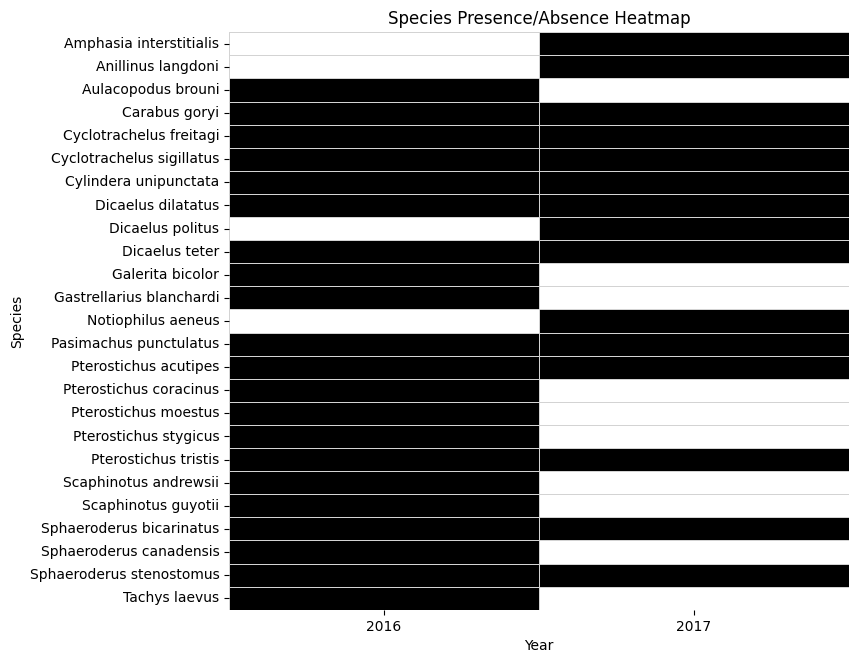

In [20]:
import geopandas as gpd
import pandas as pd
import seaborn as sns

# Load the GBIF records
gbif_geojson = "gbif_carabids_gsmnp_2016_2017.geojson"
gdf = gpd.read_file(gbif_geojson)

# Create a presence flag by dropping duplicate species–year pairs
presence_df = (
    gdf[['species', 'year']]
    .drop_duplicates()           # keep one row per species/year
    .assign(presence=1)          # mark presence
)

# Pivot so each species is a row, columns are years, values are presence (1) or absence (0)
presence_pivot = (
    presence_df
    .pivot(index='species', columns='year', values='presence')
    .fillna(0)
    .astype(int)
)

print(presence_pivot)

plt.figure(figsize=(8, max(4, len(presence_pivot) * 0.3)))
sns.heatmap(presence_pivot, cmap='Greys', cbar=False, linewidths=.5, linecolor='lightgray')
plt.xlabel("Year")
plt.ylabel("Species")
plt.title("Species Presence/Absence Heatmap")
plt.show()



#### NBR values as a proxy for burn severity compared to trap areas

In [84]:
import json

# Specify the local path to your GeoJSON file.
geojson_path = '/Users/kitlewers/NEON_GBIF_Burn_Scar/code/gbif_carabids_gsmnp_2016_2017.geojson'

# Open and load the GeoJSON as a Python dictionary.
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Extract unique coordinate pairs from the features.
# We assume each feature is a Point geometry.
unique_coords = {}
for feature in geojson_data['features']:
    # Get geometry details.
    geom = feature.get('geometry', {})
    if geom.get('type') == 'Point':
        # Coordinates are typically stored as [longitude, latitude].
        coord = tuple(geom.get('coordinates'))
        # Use the coordinates as a key to deduplicate.
        if coord not in unique_coords:
            unique_coords[coord] = coord

# Create a new GeoJSON with only the unique points.
unique_features = []
for coord in unique_coords.keys():
    new_feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": list(coord)
        },
        "properties": {}  # Only lat/long are kept.
    }
    unique_features.append(new_feature)

unique_geojson = {
    "type": "FeatureCollection",
    "features": unique_features
}

print("Number of unique trap points:", len(unique_features))

# Create an Earth Engine FeatureCollection from the unique GeoJSON.
traps = ee.FeatureCollection(unique_geojson)

# (Optional) Visualize the unique trap points using geemap.
Map = geemap.Map(center=[35.7, -83.5], zoom=11)
Map.addLayer(traps, {}, 'Unique Trap Coordinates')


Number of unique trap points: 4


In [85]:
burn_mask = burned_area_mask.unmask(0).toFloat().rename('burn_mask')

traps_buffered = traps.map(lambda feature: feature.buffer(300))

# Step 4: Define a function to compute the percentage of burned pixels within each buffer.
def calculate_burn_percentage(feature):
    stats = burn_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10,          # Adjust scale to match your sensor's resolution (e.g., 10 m)
        maxPixels=1e6
    )
    # The mean value corresponds to the fraction of burned pixels (0–1).
    burn_fraction = ee.Number(stats.get('burn_mask'))
    burn_percentage = burn_fraction.multiply(100)
    return feature.set({'burn_pct': burn_percentage})

# Apply the function to each buffered trap.
traps_with_burn = traps_buffered.map(calculate_burn_percentage)

# Optionally, print a sample of the computed burn percentages.
print('Burn percentages for trap buffers:', traps_with_burn.limit(10).getInfo())

# (Optional) Visualize the trap areas with burn percentage values on your existing map.
NBR_Map.addLayer(traps_with_burn, {}, 'Trap Areas with Burn %')


# Convert the Earth Engine FeatureCollection (with burn percentages) to a GeoDataFrame
gdf_traps = geemap.ee_to_gdf(traps_with_burn)
print("Converted GeoDataFrame:")
print(gdf_traps.head())

# Option 1: Export as CSV using pandas.
# For CSV export, the geometry column may be better exported as WKT.
gdf_traps_csv = gdf_traps.copy()
gdf_traps_csv['geometry'] = gdf_traps_csv['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)
csv_filename = "Trap_Burn_Percentage_Export.csv"
gdf_traps_csv.to_csv(csv_filename, index=False)
print(f"Data exported as CSV: {csv_filename}")

# Option 2: Export as GeoJSON using GeoPandas.
# Here, we'll export the GeoDataFrame directly as a GeoJSON file.
geojson_filename = "Trap_Burn_Percentage_Export.geojson"
# (Make sure the geometry column contains proper shapely geometries; if you already converted to WKT above, use the original gdf_traps.)
gdf_traps.to_file(geojson_filename, driver="GeoJSON")
print(f"Data exported as GeoJSON: {geojson_filename}")


Burn percentages for trap buffers: {'type': 'FeatureCollection', 'columns': {'burn_pct': 'Number', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-83.524234, 35.66718965978545], [-83.52516215579463, 35.66708220976496], [-83.52601642338209, 35.666768413553044], [-83.52672879824308, 35.66627325155342], [-83.52724257421, 35.665636141589395], [-83.5275168576299, 35.66490780033122], [-83.52752982158954, 35.66414620540121], [-83.52728044145039, 35.663411979837626], [-83.52678857413409, 35.66276356647543], [-83.52609337555741, 35.66225257637097], [-83.52525018279847, 35.661919681388035], [-83.52432610949305, 35.66179137763752], [-83.52339470499562, 35.66187787711393], [-83.52253010199786, 35.662172295127625], [-83.52180111778353, 35.66265119811748], [-83.5212657779688, 35.663276468303174], [-83.52096669813993, 35.66399833695631], [-83.5209276908613, 35.664759345124196], [-83.52115186838236, 35.66549891680321], [-83.52162139263402,

INFO:Created 4 records


Converted GeoDataFrame:
                                            geometry   burn_pct
0  POLYGON ((-83.52753 35.66415, -83.52728 35.663...   5.093100
1  POLYGON ((-83.48557 35.67878, -83.48532 35.678...  23.721914
2  POLYGON ((-83.48495 35.67043, -83.4847 35.6697...   9.383024
3  POLYGON ((-83.5354 35.68425, -83.53515 35.6835...  13.115131
Data exported as CSV: Trap_Burn_Percentage_Export.csv
Data exported as GeoJSON: Trap_Burn_Percentage_Export.geojson


Occurrence data (pivot table):
year               location  2016  2017
0      35.66449, -83.524234    59    24
1     35.670778, -83.481653    99    45
2     35.679121, -83.482275    63    42
3     35.684589, -83.532102    53    31
Burn percentage data:
                location   burn_pct
0   35.66449, -83.524234   5.093100
1  35.679121, -83.482275  23.721914
2  35.670778, -83.481653   9.383024
3  35.684589, -83.532102  13.115131
Merged data:
                location  2016  2017   burn_pct
0   35.66449, -83.524234    59    24   5.093100
1  35.670778, -83.481653    99    45   9.383024
2  35.679121, -83.482275    63    42  23.721914
3  35.684589, -83.532102    53    31  13.115131


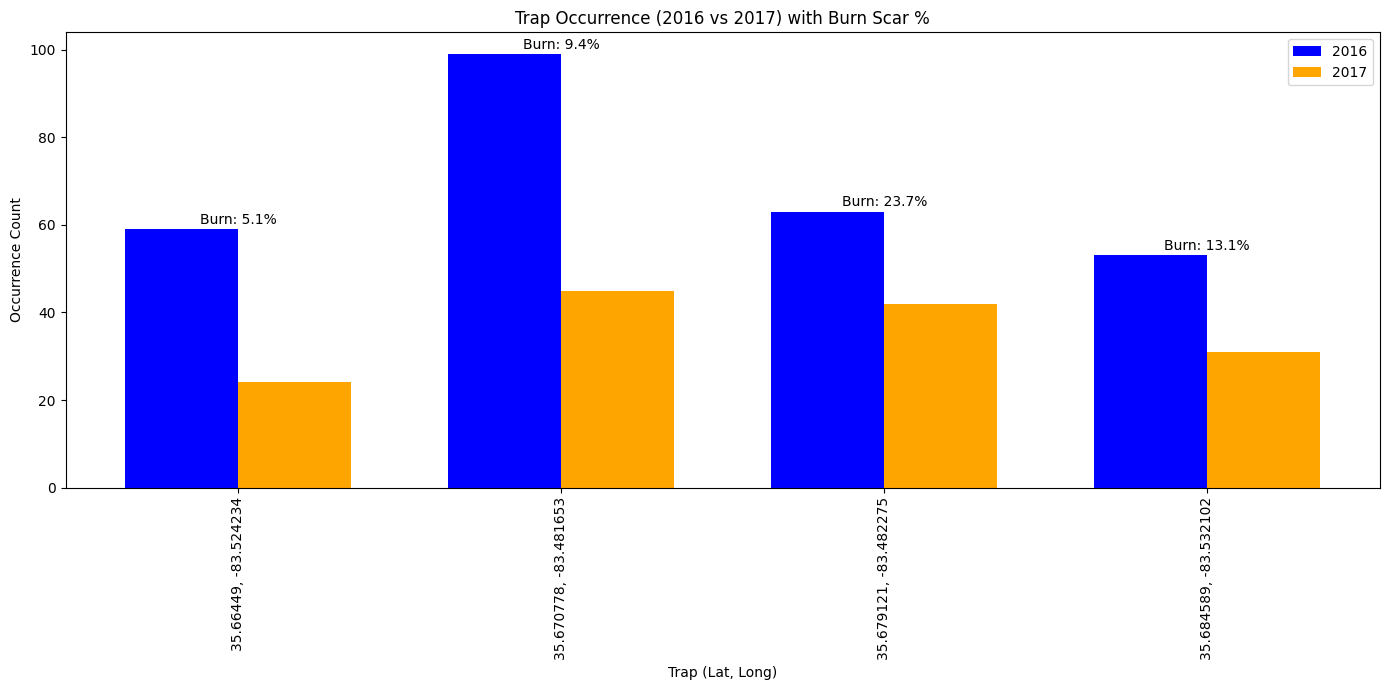

In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# ================================
# Step 1: Process occurrence data
# ================================

# Load the GBIF records from your GeoJSON file
occurrences_gdf = gpd.read_file("gbif_carabids_gsmnp_2016_2017.geojson")

# Create a new column that identifies each unique trap location.
# (We round the coordinates to 6 decimals to avoid slight floating-point mismatches.)
occurrences_gdf['location'] = occurrences_gdf['latitude'].round(6).astype(str) + ", " + occurrences_gdf['longitude'].round(6).astype(str)

# Group by year and location to count the number of occurrences per trap for each year.
occurrence_counts = occurrences_gdf.groupby(['year', 'location']).size().reset_index(name='count')

# Pivot the table so that each row is a unique trap (location) with columns for 2016 and 2017.
pivot_abundance = occurrence_counts.pivot(index='location', columns='year', values='count').fillna(0)
pivot_abundance = pivot_abundance.sort_index().reset_index()

print("Occurrence data (pivot table):")
print(pivot_abundance)


# ============================================
# Step 2: Load and process burn percentage data
# ============================================

# Load your exported CSV from Earth Engine.
# This file is assumed to be generated from your export task ("Trap_Burn_Percentage_Export.csv").
df_burn = pd.read_csv("Trap_Burn_Percentage_Export.csv")

# Convert the geometry column (assumed to be in WKT format) into shapely geometry objects.
# The CSV export from EE typically includes a column "geometry" with WKT strings.
df_burn['geometry'] = df_burn['geometry'].apply(wkt.loads)

# Create a GeoDataFrame from the burn data.
gdf_burn = gpd.GeoDataFrame(df_burn, geometry='geometry', crs="EPSG:4326")

# Compute the centroid for each (buffer) polygon.
gdf_burn['centroid'] = gdf_burn.geometry.centroid

# Extract longitude and latitude from the centroids and round for consistent merging.
gdf_burn['lon'] = gdf_burn.centroid.x.round(6)
gdf_burn['lat'] = gdf_burn.centroid.y.round(6)

# Create a location string to match the occurrence data formatting.
gdf_burn['location'] = gdf_burn['lat'].astype(str) + ", " + gdf_burn['lon'].astype(str)

# Keep only the necessary columns (location and burn percentage)
burn_data = gdf_burn[['location', 'burn_pct']]

print("Burn percentage data:")
print(burn_data)


# ===============================================
# Step 3: Merge occurrence and burn percentage data
# ===============================================

# Merge the pivot abundance table with the burn data on the "location" column.
merged_df = pd.merge(pivot_abundance, burn_data, on='location', how='left')

print("Merged data:")
print(merged_df)


# ===================================================
# Step 4: Create the visualization (grouped bar chart)
# ===================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Use the index (0, 1, 2, ...) for unique traps.
x_positions = range(len(merged_df))
bar_width = 0.35

# Plot bars for each year. We assume the pivot table columns are either integer years or strings.
# If needed, adjust the column names accordingly.
year2016 = merged_df[2016] if 2016 in merged_df.columns else merged_df['2016']
year2017 = merged_df[2017] if 2017 in merged_df.columns else merged_df['2017']

bars1 = ax.bar([i - bar_width/2 for i in x_positions], year2016, bar_width, label='2016', color='blue')
bars2 = ax.bar([i + bar_width/2 for i in x_positions], year2017, bar_width, label='2017', color='orange')

# Annotate each group with the burn percentage.
for i, row in merged_df.iterrows():
    # Get the maximum occurrence count between the two years for placement of text.
    max_count = max(row[2016] if 2016 in merged_df.columns else row['2016'], 
                    row[2017] if 2017 in merged_df.columns else row['2017'])
    ax.text(i, max_count + 0.5, f"Burn: {row['burn_pct']:.1f}%", ha='center', va='bottom', fontsize=10)

# Set the x-axis tick labels to be the location strings (which are "lat, long").
ax.set_xticks(x_positions)
ax.set_xticklabels(merged_df['location'], rotation=90)
ax.set_xlabel("Trap (Lat, Long)")
ax.set_ylabel("Occurrence Count")
ax.set_title("Trap Occurrence (2016 vs 2017) with Burn Scar %")
ax.legend()

plt.tight_layout()
plt.show()
